<a href="https://colab.research.google.com/github/entc-17-fyp-20/CM_Normal_Behaviour_Modeling/blob/akeshala/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and datasets

In [3]:
# multivariate data preparation
from numpy import array
from numpy import hstack
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, Dropout
from keras.layers.convolutional import Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [5]:
#@title Select Dataset New { display-mode: "form" }
turbine = 'T01' #@param ["T01", "T02","T03","T22","T34","T54"]
path = '/content/drive/MyDrive/IIoT - Wind Turbine/FYP/Dataset/Merged/' + turbine + '.csv'
df = pd.read_csv(path)

In [6]:
n_steps = 144

In [7]:
#@title Select scaling method { display-mode: "form" }
method = 'MinMax' #@param ["Normalize", "MinMax"]

df_time = df["Date_Time"]
df.drop("Date_Time", axis='columns', inplace=True)
column_names = df.columns

if method == "Normalize":
  d = preprocessing.normalize(df, axis=0)
else:
  scaler = preprocessing.MinMaxScaler()
  d = scaler.fit_transform(df)

df = pd.DataFrame(d, columns=column_names)
df["Date_Time"] = df_time
df = df.set_index(df['Date_Time'])

In [8]:
n_features = 4

format = '%Y-%m-%d %H:%M:%S'
split_index=[];
split_index.append(df['Date_Time'][0])
for i in range(0,len(df['Date_Time'])-1):
  current_time =  df['Date_Time'][i]
  following_time=  df['Date_Time'][i+1]
  time_gap =datetime.strptime(following_time, format)-datetime.strptime(current_time, format)
  if (time_gap.seconds > 600*5):
    split_index.append(current_time)
    split_index.append(following_time)
split_index.append(df['Date_Time'][len(df['Date_Time'])-1])

df = df.set_index(df['Date_Time'])

In [9]:
X_concat_train, y_concat_train, y_concat_test, X_concat_test = [],[],[],[]

for i in range(0,len(split_index),2):
  dfx = df[split_index[i]:split_index[i+1]]
  if len(dfx)>=144:
    dfx = dfx[['Active_Power','Ambient_Temperature','Wind_Speed','Generator_RPM','Gear_Oil_Tempeature']]
    dfx = dfx.to_numpy()
    # convert into input/output
    X, y = split_sequences(dfx, n_steps)
    if i<len(split_index)*0.8:
      X_concat_train.append(X)
      y_concat_train.append(y)
    else:
      X_concat_test.append(X)
      y_concat_test.append(y)

X_concat_train = tuple(X_concat_train)
y_concat_train = tuple(y_concat_train)

X_concat_test = tuple(X_concat_test)
y_concat_test = tuple(y_concat_test)

In [10]:
X_train = np.concatenate(X_concat_train)
y_train = np.concatenate(y_concat_train)

X_test = np.concatenate(X_concat_test)
y_test = np.concatenate(y_concat_test)

In [11]:
print("Train "+str(len(X_train)))
print("Test "+str(len(X_test)))
print(X_train.shape)
print(y_train.shape)

Train 63396
Test 8326
(63396, 144, 4)
(63396,)


# Model

In [12]:
def create_model():
# define model
  model1 = Sequential()
  model1.add(Conv1D(filters=128, kernel_size=32, activation='relu', input_shape=(n_steps, n_features)))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(Conv1D(filters=128, kernel_size=18, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(Conv1D(filters=128, kernel_size=8, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(Conv1D(filters=128, kernel_size=8, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  # model1.add(LocallyConnected2D(10, (3, 3)))
  model1.add(Flatten())
  model1.add(Dense(20, activation='relu'))
  model1.add(Dense(1, activation='tanh'))
  model1.compile(optimizer='adam', loss='mse')
  return model1

# Training 

In [13]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [14]:
n_features = X_train.shape[2]

model = create_model()

# fit model
history = model.fit(X_train, y_train, batch_size=5, validation_data=(X_test,y_test), callbacks=[earlystop, best_val], epochs=10, verbose=1)

Epoch 1/10
12680/12680 [==============================] - 776s 61ms/step - loss: 0.1847 - val_loss: 0.1358
Epoch 2/10
12680/12680 [==============================] - 795s 63ms/step - loss: 0.2142 - val_loss: 0.1358
Epoch 3/10
12680/12680 [==============================] - 792s 62ms/step - loss: 0.1601 - val_loss: 0.1358
Epoch 4/10
12680/12680 [==============================] - 795s 63ms/step - loss: 0.1592 - val_loss: 0.1358


In [15]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

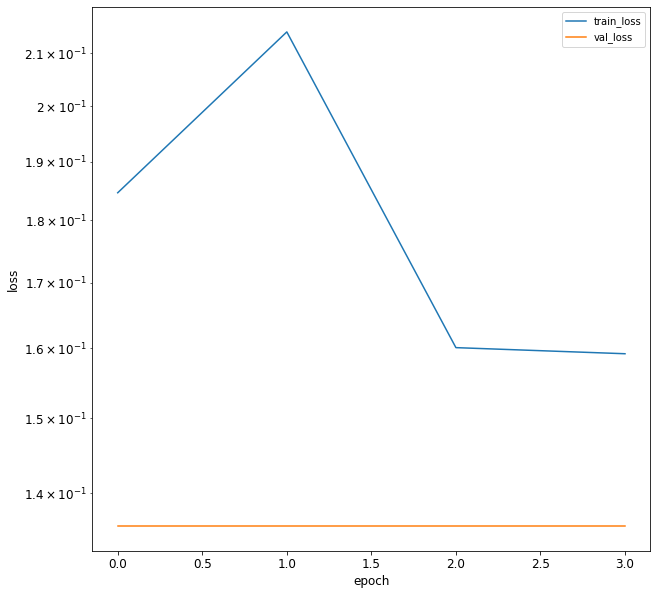

In [16]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [32]:
# Save the weights
path = '/content/drive/MyDrive/Machine Learning Models/FYP/CNN2/'
model.save_weights(path)

# Import pre-trained weights

In [33]:
path = '/content/drive/MyDrive/Machine Learning Models/FYP/CNN2/'
# Create a new model instance
model = create_model()
# Restore the weights
model.load_weights(path)

# Testing on the same turbine

In [34]:
# demonstrate prediction
yhat = model.predict(X_test, verbose=0)

In [35]:
yhat = yhat.reshape(yhat.shape[0],)
df_final=pd.DataFrame({'y_hat':yhat,'y_test':y_test})

In [36]:
df_final['difference'] = df_final['y_hat']-df_final['y_test']
df_final["abs_difference"] = abs(df_final['y_hat']-df_final['y_test'])
print(df_final["difference"].mean())
print(df_final["abs_difference"].mean())

0.3032644727360051
0.3032644727360051


In [37]:
df_final.to_csv('drive/MyDrive/DatasetsWind/df_final.csv', index=False)

# Results, Plots

In [38]:
# Adding data_time column back
frames = []

for i in range(0,len(split_index),2):
  dfx = df[split_index[i]:split_index[i+1]]

  if i>=len(split_index)*0.8:
    frames.append(dfx.iloc[n_steps-1:,:])

test = pd.concat(frames)
test.drop("Date_Time", axis='columns', inplace=True)
test = test.reset_index()
df_final["Date_Time"] = test["Date_Time"]

In [39]:
column_name = 'y_test' 
column_name1 = 'y_hat'

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=df_final['Date_Time'],y=df_final[column_name1], mode='lines', name='Predicted'))
fig.update_layout(title_text= "Actual vs Predicted")

fig.show()

In [40]:
column_name = 'difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Error'))
fig.update_layout(title_text= "Error")

fig.show()

In [41]:
column_name = 'abs_difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Absolute Error'))
fig.update_layout(title_text= "Absolute Error")

fig.show()

Re-sampling data

In [27]:
#@title Resampling { display-mode: "form" }
sample_frequency = 60 #@param {type:"slider", min:20, max:120, step:10}
sample = str(sample_frequency) + "min"

In [28]:
df_final['Date_Time'] = pd.to_datetime(df_final['Date_Time'], format="%Y-%m-%d %H:%M:%S")
df_final.set_index('Date_Time', inplace = True)
df_resample = df_final.resample(sample).mean().reset_index()
df_final = df_final.reset_index()

In [29]:
df_final

,Date_Time,y_hat,y_test,difference,abs_difference
0,2018-10-27 05:30:00,1.0,0.86,0.14,0.14
1,2018-10-27 05:40:00,1.0,0.84,0.16,0.16
2,2018-10-27 05:50:00,1.0,0.84,0.16,0.16
3,2018-10-27 06:00:00,1.0,0.82,0.18,0.18
4,2018-10-27 06:10:00,1.0,0.82,0.18,0.18
...,...,...,...,...,...
8321,2018-12-29 18:10:00,1.0,0.74,0.26,0.26
8322,2018-12-29 18:20:00,1.0,0.72,0.28,0.28
8323,2018-12-29 18:30:00,1.0,0.74,0.26,0.26
8324,2018-12-29 18:40:00,1.0,0.74,0.26,0.26


In [30]:
column_name = 'difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_resample['Date_Time'], y=df_resample[column_name], mode='lines', name='Error'))
fig.update_layout(title_text= "Error")

fig.show()

In [31]:
column_name = 'abs_difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_resample['Date_Time'], y=df_resample[column_name], mode='lines', name='Absolute Error'))
fig.update_layout(title_text= "Absolute Error")

fig.show()